In [2]:
suppressMessages(library(tidyr))
suppressMessages(library(dplyr))
suppressMessages(library(pheatmap))
suppressMessages(library(ggplot2))
suppressMessages(library(patchwork))
suppressMessages(library(ggtree))
suppressMessages(library(hash))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(ggalluvial))
suppressMessages(library(grid))
suppressMessages(library(ggrepel))
suppressMessages(library(ggdark))
suppressMessages(library(tidyverse))
suppressMessages(library(ggrastr))
suppressMessages(library(ggpubr))
suppressMessages(library(readxl))
suppressMessages(library(ggsci))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))
suppressMessages(library(aplot))
suppressMessages(library(Seurat))
suppressMessages(library(gridExtra))
#suppressMessages(library(ggunchained)) # 2.5 
suppressMessages(library(cowplot)) # 2.5 
suppressMessages(library(Matrix))
suppressMessages(library(rjson))
suppressMessages(library(data.table))

# Figure 2A 

In [3]:
GetGroupCenter <- function(df_umap, group){
  GroupCenter <- df_umap %>% group_by(eval(str2lang(group))) %>% summarise(UMAP_1 = median(UMAP_1),UMAP_2 = median(UMAP_2)) %>% as.data.frame()
  colnames(GroupCenter)[1] <- "GroupCenter"
  return(GroupCenter)
}

UmapPlot <- function(df, cluster, df_center, labelfontsize, axistitlefontsize, pointsize, pointalpha,
                    xmin,xmax,ymin,ymax,mycolor,axistitlefont,axislinesize,labelfont,
                    xaxislengthfold,yaxislengthfold){
  p <- ggplot() + 
    geom_point(df, mapping=aes(x = UMAP_1, y = UMAP_2, color = eval(str2lang(cluster))), size = pointsize, 
               alpha = pointalpha) +
    theme_void()+
    scale_x_continuous(limits = c(xmin-2, xmax))+
    scale_y_continuous(limits = c(ymin-2, ymax))+
    theme(axis.text = element_blank())+
    theme(axis.ticks = element_blank())+
    theme(panel.border = element_blank())+
    theme(axis.title = element_blank())+
    scale_color_manual(values=mycolor)+
    geom_segment(aes(x=xmin, y=ymin, xend=xmin+abs(xmin)*xaxislengthfold, yend=ymin), 
                 arrow = arrow(length=unit(0.2, "cm")), color="black", linewidth=axislinesize)+
    geom_segment(aes(x=xmin, y=ymin, xend=xmin, yend=ymin+abs(ymin)*yaxislengthfold), 
                 arrow = arrow(length=unit(0.2, "cm")), color="black", linewidth=axislinesize)+
    annotate("text", x = xmin + 1.5, y = ymin - 1, label = "UMAP_1",
             color="black",size = axistitlefontsize, fontface="bold", family = axistitlefont) +
    annotate("text", x = xmin - 1, y = ymin + 1.5, label = "UMAP_2",
             color="black",size = axistitlefontsize, fontface="bold" ,angle=90, family = axistitlefont) +
    geom_text(data = df_center[which(df_center$GroupCenter %in% unique(df[,cluster])),], mapping=aes(x = UMAP_1, y = UMAP_2, label=GroupCenter), 
              fontface="bold",color = "black",size = labelfontsize, family = labelfont)+
    theme(legend.position = "none")
  return(p)
}
RunUmapPlot <- function(obj,FilterCluster = NULL,umapCluster,ClusterColour = NULL,
                       specificgroup = NULL,umapGroup = NULL,
                       pointsize = 0.1,pointalpha = 0.5,
                       labelfontsize = 5,axistitlefontsize = 5,
                       axistitlefont = "sans",axislinesize = 1,
                       labelfont = "sans",plot_width = 10,plot_height = 8,
                        xaxislengthfold = 1,yaxislengthfold= 1,cellcycle_annotation = NULL,
                        saveannotation = TRUE,Legend = TRUE,legendnumsize = 3,
                       legendnumfont = "sans",legendlabelfontsize = 5,
                        legendlabelfont = "sans",legendwidth = 6,
                        legendheight = 5,file_name){
    df_umap_ct = obj@reductions$umap@cell.embeddings %>%
      as.data.frame() %>% 
      cbind(Cluster = obj@meta.data$clusters) %>%
      cbind(Group = obj@meta.data$mice) 
    if (is.null(obj@meta.data$tissue2)){
      df_umap_ct$Tissue <- obj@meta.data$tissue
    }else{
      df_umap_ct$Tissue <- obj@meta.data$tissue2
    }
    if (!is.null(obj@meta.data$platform)){
      df_umap_ct$Platform <- obj@meta.data$platform
      df_umap_ct$Platform <- as.factor(df_umap_ct$Platform)
    }

    df_umap_ct$Cluster <- as.factor(df_umap_ct$Cluster)
    df_umap_ct$Cluster <- factor(df_umap_ct$Cluster, levels=sort(as.numeric(levels(df_umap_ct$Cluster))))
    df_umap_ct$Group <- as.factor(df_umap_ct$Group)
    df_umap_ct$Tissue <- as.factor(df_umap_ct$Tissue)

    if (!is.null(FilterCluster)){
      if (filtercluster_var == umapCluster){
        df_umap_ct <- df_umap_ct[which(!df_umap_ct[,umapCluster] %in% FilterCluster),]
      }else{
        df_umap_ct <- df_umap_ct[which(!df_umap_ct[,filtercluster_var] %in% FilterCluster),]
      }
    }

    xmin <- min(df_umap_ct$UMAP_1)-2
    xmax <- max(df_umap_ct$UMAP_1)+2
    ymin <- min(df_umap_ct$UMAP_2)-2
    ymax <- max(df_umap_ct$UMAP_2)+2
    
    # lwm 
    # print(head(df_umap_ct))

    ct_center <- GetGroupCenter(df_umap_ct, umapCluster)
    

    nCluster = length(unique(df_umap_ct[,umapCluster]))

    if (is.null(ClusterColour)){
      mycolor = colorRampPalette(brewer.pal(9, "Set1"))(nCluster)
      names(mycolor) <- levels(df_umap_ct[,umapCluster])[sort(unique(df_umap_ct[,umapCluster]))]
    }else{
      if (is.null(names(ClusterColour))){
        mycolor <- ClusterColour
        names(mycolor) <- levels(df_umap_ct[,umapCluster])[sort(unique(df_umap_ct[,umapCluster]))]
      }else{
        mycolor <- ClusterColour
      }
    }

  
    if (is.null(specificgroup)){
      if (is.null(umapGroup)){
        umap_overall <- UmapPlot(df_umap_ct, umapCluster, ct_center, labelfontsize, axistitlefontsize,
                                 pointsize, pointalpha,xmin,xmax,ymin,ymax,mycolor,axistitlefont,axislinesize,
                                 labelfont,xaxislengthfold,yaxislengthfold)
        ggsave(paste0(file_name,"_umap_overall_",umapCluster,".pdf"),umap_overall,device='pdf',width = plot_width, 
               height = plot_height)
      }
    }

    if (is.null(cellcycle_annotation)){
      ct_anno <- unique(data.frame(Cluster=obj@meta.data$cluster, ClusterName=obj@meta.data$celltypes))
      ct_anno$Cluster <- factor(ct_anno$Cluster, levels=sort(as.numeric(levels(ct_anno$Cluster))))
      cellcycle_annotation <- ct_anno[order(ct_anno$Cluster, decreasing = F),]
      if (!is.null(FilterCluster)){
        cellcycle_annotation <- cellcycle_annotation[which(!cellcycle_annotation$Cluster %in% FilterCluster),]
      }
  if (saveannotation){
    write.table(cellcycle_annotation, paste0(file_name,"_cellcycle_annotation.txt"), 
                                             sep = "\t", quote = F, row.names = F)
  }
    }else{
      cellcycle_annotation <- read.table(cellcycle_annotation, sep="\t", header = T)
      cellcycle_annotation$Cluster <- as.factor(cellcycle_annotation$Cluster)
      cellcycle_annotation$Cluster <- factor(cellcycle_annotation$Cluster, levels=sort(as.numeric(levels(cellcycle_annotation$Cluster))))
      cellcycle_annotation <- cellcycle_annotation[order(cellcycle_annotation$Cluster),]
    }

    if (Legend){
      if (!is.null(FilterCluster)){
        cellcycle_annotation <- cellcycle_annotation[which(!cellcycle_annotation$Cluster %in% FilterCluster),]
      }
  
      xend <- ceiling(nCluster/15)
      xeach <- ceiling(nCluster/xend)
      xlist <- sort(rep(c(1:xend), each=xeach, length.out = nCluster))
      df_xlist <- table(xlist) %>% as.data.frame()
      ylist <- rep(c(max(df_xlist$Freq):1),nrow(df_xlist), length.out=nCluster)
  
      df_legend <- cellcycle_annotation
      df_legend$x <- xlist
      df_legend$y <- ylist
  
      p_lgd <- ggplot(df_legend, aes(x=x, y=y))+
        geom_point(alpha=1, size=6,aes(colour=as.factor(Cluster)))+
        labs(x='',y='',title="")+
        geom_text(aes(x=x, y=y,label=Cluster), fontface="bold",color = "black",size = legendnumsize,
                  family = legendnumfont)+
        geom_text(aes(x=x+xend*0.03, y=y,label=ClusterName), fontface="bold",color = "black",
                  size = legendlabelfontsize, family = legendlabelfont, hjust = 0)+
        theme_void()+
        scale_x_continuous(limits = c(1, xend+1))+
        theme(axis.text = element_blank())+
        theme(axis.ticks = element_blank())+
        theme(panel.border = element_blank())+
        theme(axis.title = element_blank())+
        scale_color_manual(values=mycolor)+
        theme(legend.position = "none")
      ggsave(paste0(file_name,"_umap_legend.pdf"),p_lgd,device='pdf',width = legendwidth, height = legendheight) 
    }
    plst <- list(p = umap_overall,lgd = p_lgd)
    return(plst)
}

In [4]:
bcells <- readRDS("immune_bcells_final_annotation.rds")

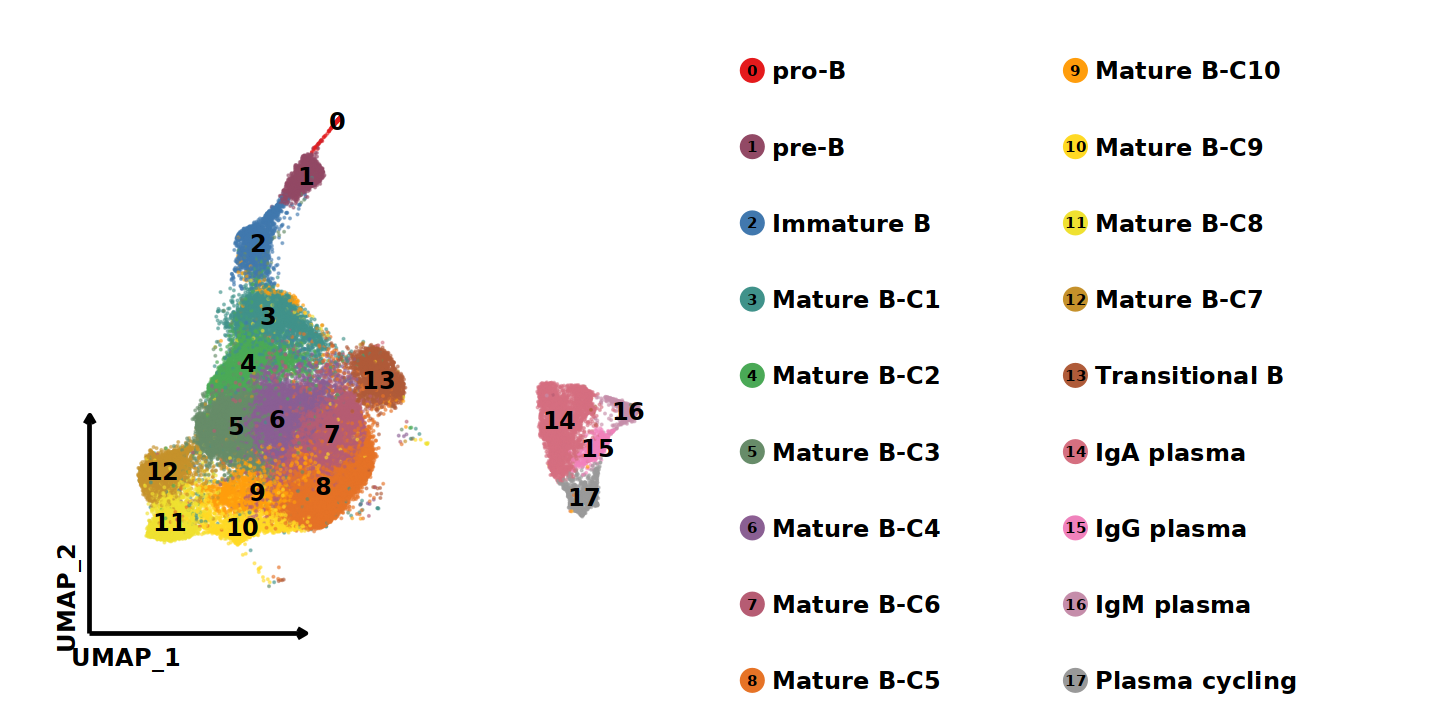

In [5]:
p <- RunUmapPlot(bcells,umapCluster = "Cluster",file_name = "Figure_2A_bcells")
options(repr.plot.width =12,repr.plot.height= 6)
p[["p"]] + p[["lgd"]] 

# Figure 2B

In [7]:
CellCyclePlot <- function(df, groupname,labelfontsize,labelfont,plottitlefontsize,
                          plottitlefont,mycolor2,file_name){
  df$Overall <- apply(df,1,sum)
  
  SumAll <- sum(df$Overall)
  df$gap <- SumAll*0.01
  df$Overall <- NULL
  df <- rownames_to_column(df, var = "Cluster")

  df_long <- reshape2::melt(df, id.var="Cluster", variable.name="CellCycle", value.name = "Value")
  
  df_long$Cluster <- as.factor(df_long$Cluster)
  df_long$Cluster <- factor(df_long$Cluster, levels=sort(as.numeric(levels(df_long$Cluster))))
  df_long$CellCycle <- factor(df_long$CellCycle, levels=c("G1","G2M","S","gap"))
  
  df_long <- df_long[order(df_long[,"Cluster"],df_long[,"CellCycle"]),]
  
  df_long$fraction = df_long$Value / SumAll
  df_long$ymax = cumsum(df_long$fraction)
  df_long$ymin = c(0, head(df_long$ymax, n = -1))
  
  write.csv(df_long, paste0(file_name,"_df_long_",groupname,".csv"),row.names = F) # ok # 
  
  df_long_center <- df_long[which(df_long$CellCycle!="gap"),c("Cluster","ymax","ymin")]
  df_center <- reshape2::melt(df_long_center, id.var="Cluster")
  df_center_y <- df_center %>% group_by(Cluster) %>% dplyr::summarise(ymin=min(value),
                                                                      ymax=max(value)) %>% as.data.frame()
  df_center_y$ymean <- (df_center_y$ymax + df_center_y$ymin)/2
    
  p <- ggplot() +
    geom_rect(data = df_long[which(df_long$CellCycle!="gap"),], aes(fill = Cluster, ymax = ymax, ymin = ymin, xmax = 7, xmin = 3),show.legend = F) +
    geom_rect(data = df_long[which(df_long$CellCycle=="gap"),], aes( ymax = ymax, ymin = ymin, xmax = 7, xmin = 3),fill = "black",show.legend = F) +
    geom_rect(data = df_long, aes(fill = CellCycle, ymax = ymax, ymin = ymin, xmax = 8, xmin = 7.1),show.legend = F) +
    geom_text(data = df_center_y, aes(x=rep(9,nrow(df_center_y)),y=ymean,label=Cluster), fontface="bold",
              color = "black",size = labelfontsize, family = labelfont)+
    annotate("text", x = 0.1, y = median(df_long$ymax), label = groupname,
             color="black",size = plottitlefontsize, family = plottitlefont, fontface="bold", angle=0)+
    scale_fill_manual(values=mycolor2)+
    coord_polar(theta = "y") +
    xlim(c(0, 10)) +
    # theme_light() +
    theme_bw()+
    labs(x="",y="")+
    theme(panel.grid=element_blank()) + 
    theme(axis.text=element_blank()) + 
    theme(axis.ticks=element_blank()) + 
    theme(panel.border=element_blank()) 
  return(p)
}

df_rename <- function(df, annote_ct){
  df_merged <- merge(df, annote_ct, by.x="row.names", by.y="ClusterName")
  rownames(df_merged) <- df_merged$Cluster
  df_merged <- df_merged[order(df_merged$Cluster),]
  df_merged$Cluster <- NULL
  df_merged$Row.names <- NULL
  return(df_merged)
}
 
df_annot <- function(df){
  df_a_s <- NULL
  df <- rownames_to_column(df, var = "ClusterName")
    
  df$Cluster  <- seq(0,length(df$ClusterName) - 1,1)# lwm  number of Cluster ! 
    
  ct_annotation <- df[,c("Cluster","ClusterName")]
  df_selected <- df %>% select(-c("ClusterName")) %>% column_to_rownames("Cluster")
  df_a_s[[1]] <- ct_annotation
  df_a_s[[2]] <- df_selected
  return(df_a_s)
}
RunCellCyclePlot <- function(data,file_name,FilterCluster= NULL,cellcycle_annotation=NULL,
                            ClusterColour = NULL,CellCycleColour = NULL,
                            labelfontsize = 5,labelfont = "sans",plottitlefontsize = 5,
                         plottitlefont = "sans",plot_width =10,plot_height = 8,
                            Legend = TRUE,legendnumsize = 3,
                       legendnumfont = "sans",legendlabelfontsize = 5,
                        legendlabelfont = "sans",legendwidth = 6,
                        legendheight = 5){
    
    GF_Phase <- data %>% filter(mice == "GF")
    GF_Phase <- as.data.frame.array(table(GF_Phase$clusters,GF_Phase$Phase))
    
    SPF_Phase <- data %>% filter(mice == "SPF")
    SPF_Phase <- as.data.frame.array(table(SPF_Phase$clusters,SPF_Phase$Phase))

    if (!is.null(FilterCluster)){
      GF_Phase <- GF_Phase[which(!GF_Phase$clusters %in% FilterCluster),] # filter cluster !! lwm 
      SPF_Phase <- SPF_Phase[which(!SPF_Phase$clusters %in% FilterCluster),]
    }

    if (!is.null(cellcycle_annotation)){
      cellcycle_annotation <- read.table(cellcycle_annotation, sep="\t", header = T)
      GF_Phase <- df_rename(GF_Phase, cellcycle_annotation)
      SPF_Phase <- df_rename(SPF_Phase, cellcycle_annotation)
    }else{
      GF_annot_res <- df_annot(GF_Phase)
      GF_Phase <- GF_annot_res[[2]]
      SPF_annot_res <- df_annot(SPF_Phase)
      SPF_Phase <- SPF_annot_res[[2]]
      cellcycle_annotation <- SPF_annot_res[[1]]
    }

    nCluster = nrow(GF_Phase)

    if (is.null(ClusterColour)){
      mycolor = colorRampPalette(brewer.pal(9, "Set1"))(nCluster)
      names(mycolor) <- rownames(GF_Phase)
    }else{
      if (is.null(names(ClusterColour))){
        mycolor <- ClusterColour
        names(mycolor) <- rownames(GF_Phase)
      }else{
        mycolor <- ClusterColour
      }
    }

    if (is.null(CellCycleColour)){
      CellCycleColour <- c("#0073C2FF", "#EFC000FF", "#CD534CFF")
    }
    mycolor2 <- c(mycolor, "G1"=CellCycleColour[1], "G2M"=CellCycleColour[2], "S"=CellCycleColour[3],"gap"="black")
    ccp_gf <- CellCyclePlot(GF_Phase,groupname= "GF",labelfontsize,labelfont,plottitlefontsize,plottitlefont,
                           mycolor2,file_name)
    ccp_spf <- CellCyclePlot(SPF_Phase,groupname="SPF",labelfontsize,labelfont,plottitlefontsize,plottitlefont,
                             mycolor2,file_name)
    ccp_group <- ggarrange(ccp_gf, ccp_spf, ncol = 2, nrow = 1) 
    
    ggsave(paste0(file_name,"_CellCyclePlot_group.pdf"),ccp_group,device='pdf',
                  width = plot_width, height = plot_height)

    if (Legend){
      if (!is.null(FilterCluster)){
        cellcycle_annotation <- cellcycle_annotation[which(!cellcycle_annotation$Cluster %in% FilterCluster),]
      }
  
      xend <- ceiling(nCluster/15)
      xeach <- ceiling(nCluster/xend)
      xlist <- sort(rep(c(1:xend), each=xeach, length.out = nCluster))
      df_xlist <- table(xlist) %>% as.data.frame()
      ylist <- rep(c(max(df_xlist$Freq):1),nrow(df_xlist), length.out=nCluster)
  
      df_legend <- cellcycle_annotation
      df_legend$x <- xlist
      df_legend$y <- ylist
  
      df_legend2 <- data.frame(Cluster=c("G1","G2M","S"))
      df_legend2$Cluster <- as.factor(df_legend2$Cluster)
      df_legend2$y <- c(rep(0,3))
      df_legend2$x <- c(seq(1,3))
  
      p_lgd2 <- ggplot(df_legend2, aes(x=x, y=y))+
        geom_rect(data = df_legend2, aes(fill = as.factor(Cluster), ymax = y+0.02, ymin = y-0.02, xmax = x+0.05, xmin = x-0.05),show.legend = F)+
        labs(x='',y='',title="")+
        geom_text(aes(x=x+0.1, y=y,label=Cluster), fontface="bold",color = "black",size = legendlabelfontsize, family = legendlabelfont, hjust = 0)+
        geom_text(aes(x=1, y=0.1, label="Cell Cycle"), fontface="bold",color = "black",size = 6, family = legendlabelfont, hjust = 0)+
        # theme_map()+
        theme_void()+
        scale_x_continuous(limits = c(-0.5, 4))+
        scale_y_continuous(limits = c(-0.5, 0.5))+
        theme(axis.text = element_blank())+
        theme(axis.ticks = element_blank())+
        theme(panel.border = element_blank())+
        theme(axis.title = element_blank())+
        scale_fill_manual(values=CellCycleColour)+
        theme(legend.position = "none")
      ggsave(paste0(file_name,"_CellCyclePlot_legend2.pdf"),p_lgd2,device='pdf',
             width = legendwidth, height = legendheight)
    }
    plst <- list(ccp = ccp_group,lgd = p_lgd2)
    return(plst)
}

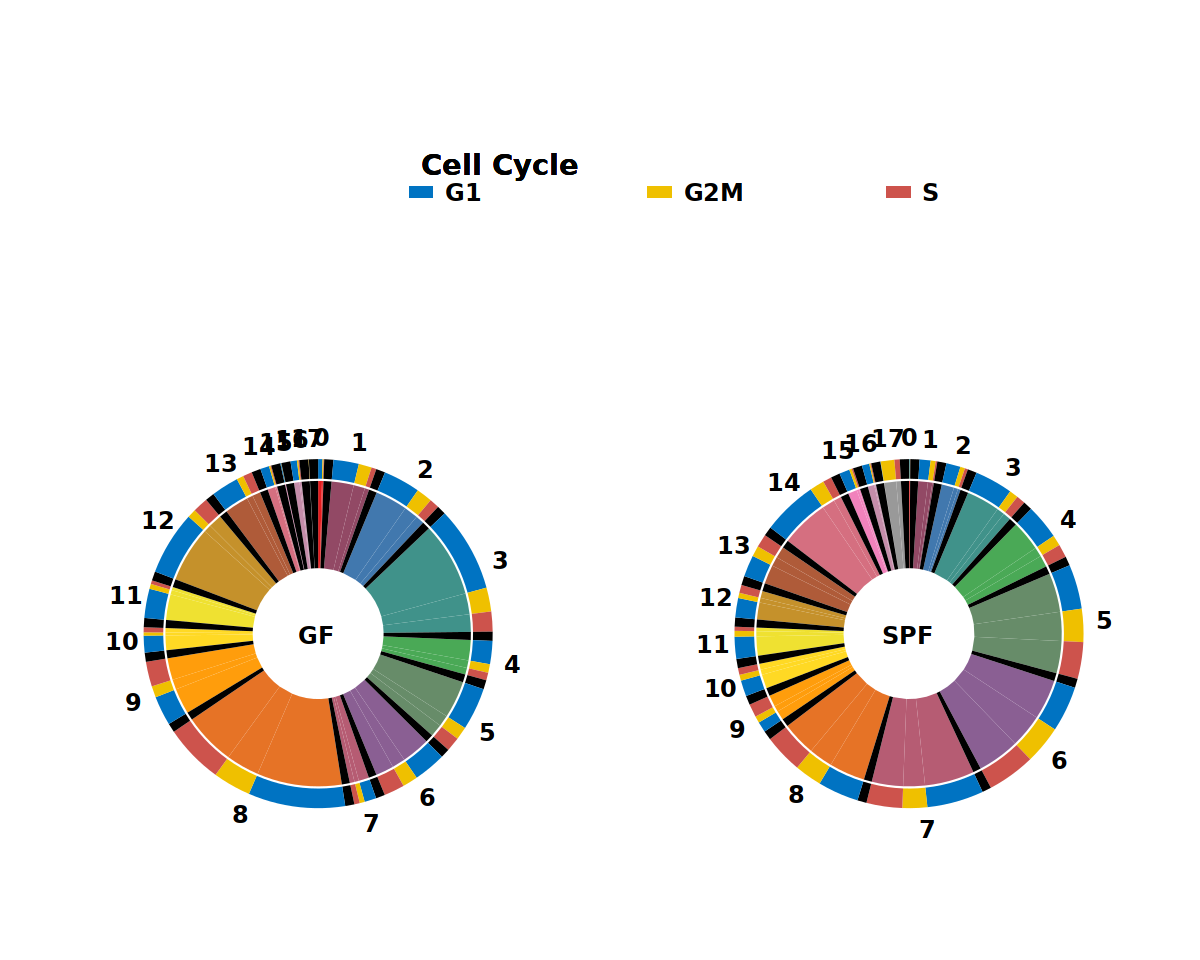

In [8]:
df <- bcells@meta.data %>% select(mice,Phase,clusters)
write.table(df,file = "Figure_2B_bcells.xls",sep = "\t",quote = F)
p <- RunCellCyclePlot(data = df,file_name = "Figure_2B_bcells")
options(repr.plot.width =10,repr.plot.height= 8)
p[["lgd"]] / p[["ccp"]] + plot_layout(heights = c(1,2))

# Figure 2C 

In [9]:
dotplot_custom <- function(df_nums,rowlist,collist,col_names){
    df_nums$celltypes <- rownames(df_nums)
    range01 <- function(x){(x - min(x)) / (max(x) - min(x))}
    df_prop <-  df_nums %>% select(-c("celltypes"))
    df_prop <- apply(df_prop, 2, function(x){x/sum(x)*100})
    rewrite0_row <- which(apply(df_prop,1,min)!=0)
    df_prop <- as.data.frame(t(apply(df_prop, 1, range01)))
    minpseudo <- min(df_prop[df_prop!=0])/2
    for (i in rewrite0_row){
      df_prop[i,which(df_prop[i,]==0)] <- minpseudo
    }
    df_prop$celltypes <- df_nums$celltypes
    
    df_prop_long <- reshape2::melt(df_prop, id.var='celltypes', variable.name='Organs', value.name = "Propstat")
    df_nums_long <- reshape2::melt(df_nums, id.var='celltypes', variable.name='Organs', value.name = "Numstat")

    df_long <- dplyr::left_join(df_prop_long,df_nums_long,by=c("celltypes","Organs"))
    df_long$celltypes <- as.factor(df_long$celltypes)
    df_long$Organs <- as.factor(df_long$Organs)
    df_long$Numstat[df_long$Numstat==0] <- NA 
    df_long$Propstat[df_long$Propstat==0] <- NA

    df_newname <- data.frame(celltypes=rowlist, newname= rowlist)

    df_long_newname <- merge(df_long,df_newname,by="celltypes",all.x = T)

    df_long <- df_long_newname[,c(5,2,3,4)]
    colnames(df_long)[1] <- "celltypes"
    
    #print(head(df_long)) 
    print(unique(df_long$celltypes)) 
    df_long$celltypes <- factor(df_long$celltypes, levels = rev(df_newname$newname))
    df_long$Organs <- factor(df_long$Organs, levels = c(collist))
    df_long$Numstat <- cut(df_long$Numstat, breaks = c(-Inf, 100, 250, 500, 750, 1000, 5000, Inf), 
                           labels = c("1-100", "101-250", "251-500", "501-750", "750-1000", "1000-5000", ">5000"), right=FALSE)

    p <- ggplot(df_long,aes(x=Organs,y=celltypes))+
              geom_point(aes(size=Propstat, color=Numstat))+
              theme_bw()+
                guides(shape = guide_legend(override.aes = list(size=20)))+
          theme(axis.text.x = element_text(size = 15, face="bold", vjust = 0.5, hjust = 0.5, angle = 0),
                axis.text.y = element_text(size = 15, face="bold"))+
          theme(legend.title = element_text(size = 15, face="bold"),
                legend.text = element_text(size = 13)) +
          scale_color_manual(values = col_names[3:10]) +  labs(x=NULL,y=NULL)  + coord_flip() 
    return(p)
}
# use cluster # 
GetMergeTable <- function(object,var){
    print(object)
    whole <- as.data.frame.array(table(object@meta.data$clusters,object@meta.data$mice))
    #print(whole)
    Idents(object) <- var
    for( i in unique(object@meta.data[,var])){
        print(i)
        subObj <- subset(object, idents = i)
        tissue_table <- as.data.frame.array(table(subObj@meta.data$clusters,subObj@meta.data$mice))
        tissue_prefix <- rep(i,2)
        table_newnames <- paste(colnames(tissue_table),tissue_prefix,sep = "_")
        colnames(tissue_table) <- table_newnames
        whole <- cbind(whole,tissue_table)
    }
    return(whole)
} 

In [15]:
dat <- GetMergeTable(object = bcells, var = "tissue")
rowlist = c(0,1,2,12,5,13,6,8,9,7,10,14,17,15,4,3,11,16)
write.table(dat,file = "Figure_2C_Bcells.xls",sep = '\t',quote = F)

An object of class Seurat 
32886 features across 55387 samples within 2 assays 
Active assay: RNA (30886 features, 0 variable features)
 1 other assay present: integrated
 3 dimensional reductions calculated: pca, umap, tsne
[1] "blood"
[1] "bm"
[1] "liver"
[1] "spleen"
[1] "thymus"
[1] "cecum"
[1] "colon"
[1] "ileum"


 [1]  0  1 10 11 12 13 14 15 16 17  2  3  4  5  6  7  8  9


Warning message:
“Removed 49 rows containing missing values (`geom_point()`).”


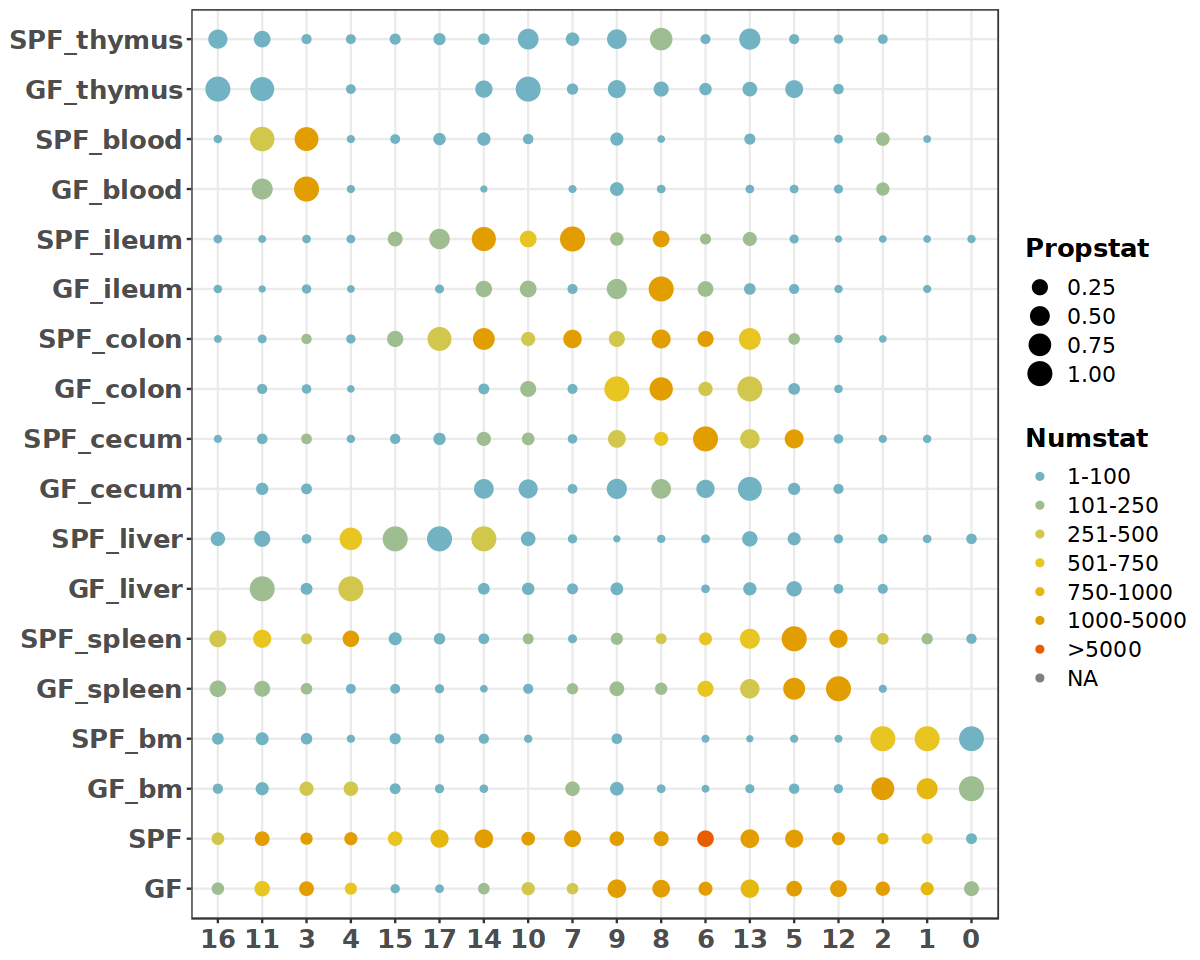

In [18]:
collist <- c("GF","SPF",
             "GF_bm","SPF_bm",
             "GF_spleen","SPF_spleen",
             "GF_liver","SPF_liver",
             "GF_cecum","SPF_cecum",
             "GF_colon","SPF_colon",
             "GF_ileum","SPF_ileum",
             "GF_blood","SPF_blood",
             "GF_thymus","SPF_thymus")
col_names <- c("#3B9AB2","#56A6BA","#71B3C2","#9EBE91","#D1C74C",
               "#E8C520","#E4B80E","#E29E00","#EA5C00","#F21A00")
options(repr.plot.width = 10,repr.plot.height= 8)
p <- dotplot_custom(df_num = dat, rowlist = rowlist,collist =  collist,col_names = col_names)  
p

In [19]:
pdf(file = 'Figure_2C_bcells_dotplot.pdf',w = 10, h = 8)
print(p)
dev.off()

Warning message:
“Removed 49 rows containing missing values (`geom_point()`).”


png 
  2

# Figure 2D

In [2]:
SplitViolinPlot <- function(data,color=c("#00AFBB", "#E7B800")){
    mytheme <- theme(
        axis.text.y = element_text(size = 20,face = "bold",margin = margin(0,5,0,0)),
        axis.text.x = element_text(size = 20,face = "bold",margin = margin(5,0,0,0),angle = 0,
                                   hjust =0.5, vjust = 1),
        axis.title.x = element_text(size = 25,face = "bold",margin = margin(10,0,0,0)),
        axis.title.y = element_text(size = 25,face = "bold",margin = margin(0,10,0,0)),
        axis.line = element_line(linetype = 1,color= "black",size = 1),
        axis.ticks = element_line(linetype = 1,color= "black",size = 1,lineend = 100),
        legend.text = element_text(size = 16,face = "bold"),
        legend.title = element_text(size = 25,face = "bold"))+ 
               theme(legend.key.size = unit(1,"cm"), 
                  legend.spacing.x = unit(0.2,'cm'),
                  legend.spacing.y = unit(0.2,'cm'),
                  legend.text = element_text(margin = margin(t = 0,r = 0,b = 0,l =  0)))+
               theme(plot.title = element_text(size = 25,hjust = 0.5,face = "bold"),
                     plot.margin = unit(c(1,1,1,1), "cm"))
    p <- ggplot(data, aes(ident, expression, fill = split)) +
         geom_split_violin(scale = "width", adjust = 1, trim = FALSE)+
         scale_fill_manual(values=color) + 
         scale_y_continuous(expand = c(0, 0),
                            position="left") +
         facet_grid(rows = vars(feature), scales = "free") + 
         theme_cowplot(font_size = 12) +
         theme(legend.position = "top",legend.justification = "center",
               panel.spacing = unit(0, "lines"),
               panel.background = element_rect(fill = NA, color = "black"),
               strip.background = element_blank(),
               strip.text = element_text(face = "bold",size = 20),
               strip.text.y.right = element_text(angle = 0,margin = margin(0,0,10,0))
              ) +
         ggtitle(" ") + ylab("Expression Level") + xlab("celltypes") + labs(fill = "mice") + mytheme 
    return(p)
} 

In [3]:
spleen <- readRDS("spleen_final_annotation.rds")

In [4]:
genelist <- c("Cr2","Ighd")
sp_sub <- subset(spleen,idents = c(0,1))
da <- VlnPlot(object = sp_sub, features = genelist, split.by = 'mice',raster=FALSE,
       stack = TRUE)$data

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



In [5]:
annot <- data.frame(ident = c("0","1"),celltypes = c("MZ B cell(c12)","FC B cell(c5)"))
da$ident <- as.vector(da$ident)

In [6]:
da <- da %>% left_join(annot,by = "ident") %>% select(feature,expression,celltypes,split) 
colnames(da)[3] <- "ident"
da$ident <- factor(da$ident,levels = c("FC B cell(c5)","MZ B cell(c12)"))
write.table(da,file = "Figure_2D.xls",sep = "\t",quote = F)

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


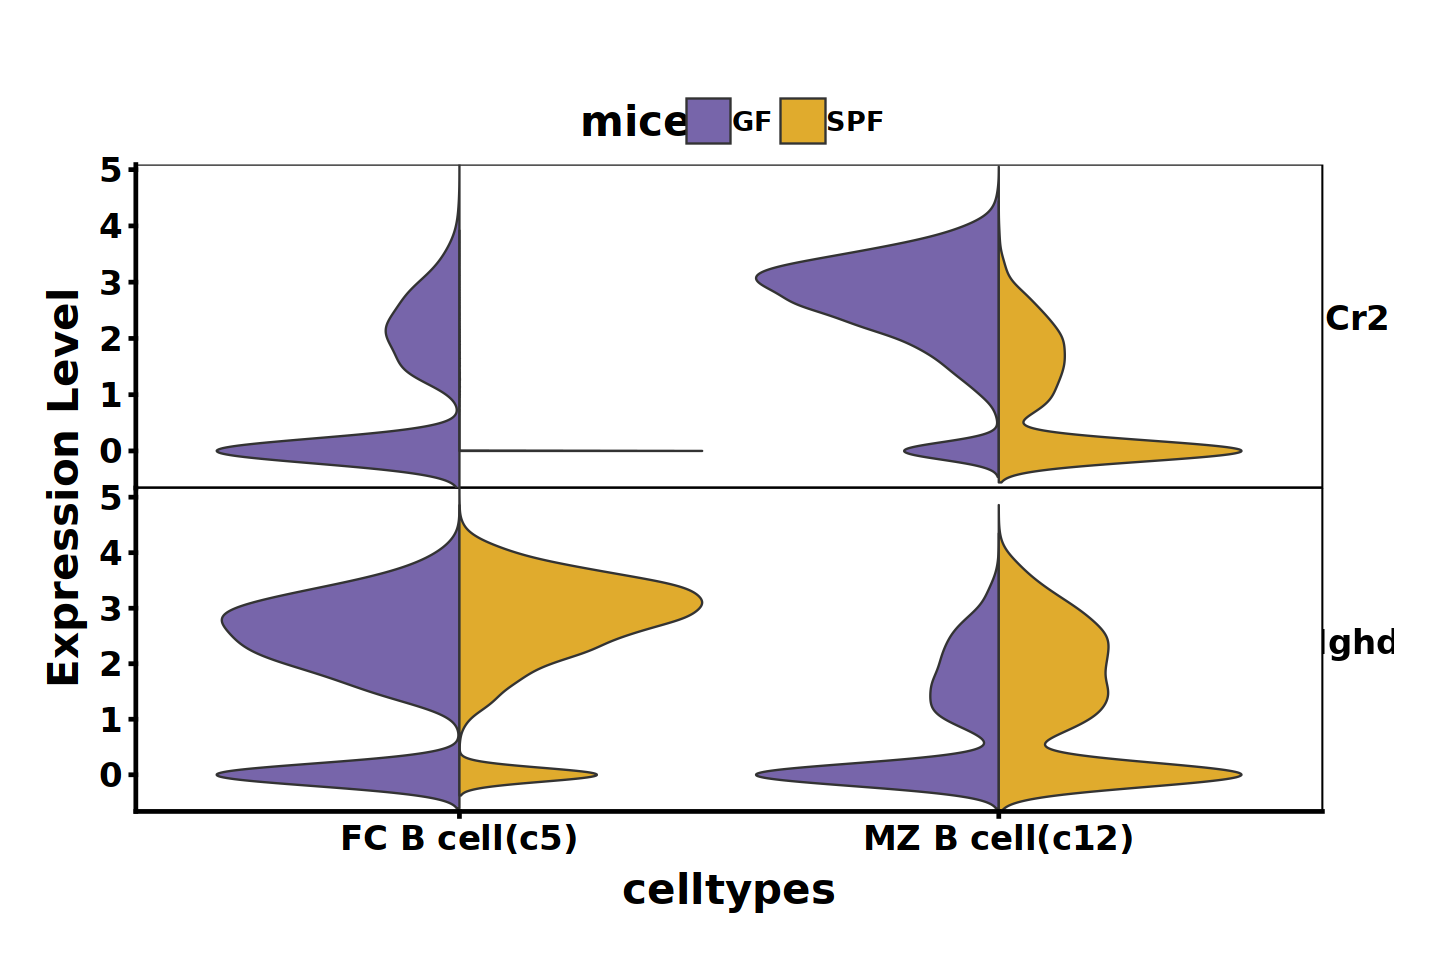

In [7]:
options(repr.plot.width = 12,repr.plot.height= 8)
mycolor <- c("#7765aa","#e0ab2d")
p <- SplitViolinPlot(data = da,color = mycolor)
p

In [8]:
pdf(file = "Figure_2D_SplitViolinPlot.pdf",w = 10,h = 8)
print(p)
dev.off()

pdf 
  2

# Figure 2F

In [71]:
CellMiceRadioBarplot <- function(data,x,y,fill,mycolor,barwidth = 0.5,title = NULL,legend = "vertical",nrow = 2){ 
  theme_self <- theme(
    axis.text.y = element_text(size = 20,face = "bold",margin  = margin(0,5,0,0)),
    axis.text.x = element_text(size = 20,face = "bold",margin  = margin(5,0,0,0),angle = 0,hjust = 0.5,vjust =0.5),
    axis.title.x= element_text(size = 25,face = "bold",margin  = margin(0,0,0,0)),
    axis.title.y= element_text(size = 25,face = "bold",margin  = margin(0,0,0,0)),
    axis.line = element_line(linetype = 1,color= "black",size = 1),
    legend.text = element_text(size = 18,face = "bold"),
    legend.title = element_text(size = 25,face = "bold"),
    panel.grid = element_blank(),
    plot.margin =  unit(c(1,1,1,1),"cm"), # lwm 2023 -7 - 7 
    axis.ticks  = element_line(color = "black",size = 1,lineend = 2),
    plot.title = element_text(hjust = 0.5,size = 30,face = "bold"))
  p <- ggplot(data,aes_string(x = x,y = y,fill = fill)) + 
    geom_bar(stat="identity",width =barwidth) + theme_classic() + labs(x = " " , y = "Percentage (%)") +  #0.25 
    scale_fill_manual(values=mycolor) + theme_self  
  if(legend == "vertical"){  
      p <- p +  theme(legend.position  = "top") +
                 guides(fill=guide_legend(title = title,title.position = "top",nrow = nrow))  
              
  } else if (legend == "horizontal"){
      p <- p + theme(legend.position = "top",legend.title = element_blank()) + 
                  guides(fill=guide_legend(nrow =nrow)) 
  } else {
      stop("Please check your parameter of legend!")
  }
  return(p)
}
# scRNA-seq stat # 
GetStat <- function(obj,annot){
    data <- as.data.frame.array(table(spleen@meta.data$cluster,spleen@meta.data$mice))
    data <- as.data.frame(proportions(as.matrix(data),margin = 2) * 100) 
    data <- data[c(1,2),]
    data$clusters <- rownames(data)
    data <- left_join(data,annot,by = "clusters")
    data$clusters <- NULL
    data <- reshape2::melt(data,id.vars = "celltypes")
    colnames(data) <- c("celltypes","mice","percentage")
    return(data)
}
# stereo stat # 
DoStat <- function(Counts,Genelist,index){
    data <- as.data.frame(Matrix::rowSums(x = Counts > 0)) # whole express gene Connts > 0 # 
    colnames(data) <- "ExpStat"
    print(dim(Counts))
    data$whole <- dim(Counts)[2] #  all spot ##
    data$gene <- rownames(data)
    data <- data %>% mutate(UnExpStat = whole - ExpStat) 
    data <- data[Genelist,]
    data <- data %>% mutate(percentage = ExpStat/whole * 100 )
    rownames(data) <- NULL
    data$mice <- index
    return(data)
}

In [72]:
spleen <- readRDS("spleen_final_annotation.rds")

In [73]:
mycolor <- c("#C3A1CA","#655883")
annot <- data.frame(clusters = c("0","1"),celltypes = c("MZ B cell","FC B cell"))
data <- GetStat(obj = spleen,annot = annot)
data$celltypes <- factor(data$celltypes,levels = c("MZ B cell","FC B cell"))
data

celltypes,mice,percentage
<fct>,<fct>,<dbl>
MZ B cell,GF,16.61264
FC B cell,GF,23.23871
MZ B cell,SPF,13.15720
FC B cell,SPF,41.33157


In [74]:
sc <- CellMiceRadioBarplot(data = data,mycolor = mycolor,barwidth = 0.65,
                           x = "mice",y = "percentage",fill = "celltypes",
                           title = "scRNA-seq",legend = "vertical",nrow = 2)

In [75]:
gf_spleen <- readRDS("GF_spleen.bin50.rds")
spf_spleen <- readRDS("SPF_spleen.bin50.rds")
date()

[1] "Thu Jan 16 21:20:44 2025"

In [76]:
gf_stat <- DoStat(Counts = gf_spleen@assays$Spatial@counts,Genelist = c("Cr2","Ighd"),index = "GF")
spf_stat <- DoStat(Counts = spf_spleen@assays$Spatial@counts,Genelist = c("Cr2","Ighd"),index = "SPF")
data <- rbind(gf_stat,spf_stat) %>% select(gene,percentage,mice)
data$gene <- factor(data$gene,levels = c("Cr2","Ighd"))
data

[1] 28222  7446
[1] 28134 11957


gene,percentage,mice
<fct>,<dbl>,<chr>
Cr2,15.21622,GF
Ighd,18.47972,GF
Cr2,17.58802,SPF
Ighd,30.50933,SPF


In [77]:
st <- CellMiceRadioBarplot(data = data,mycolor = mycolor,barwidth = 0.65,
                           x = "mice",y = "percentage",fill = "gene",
                           title = "Stereo-seq",legend = "vertical",nrow =2)

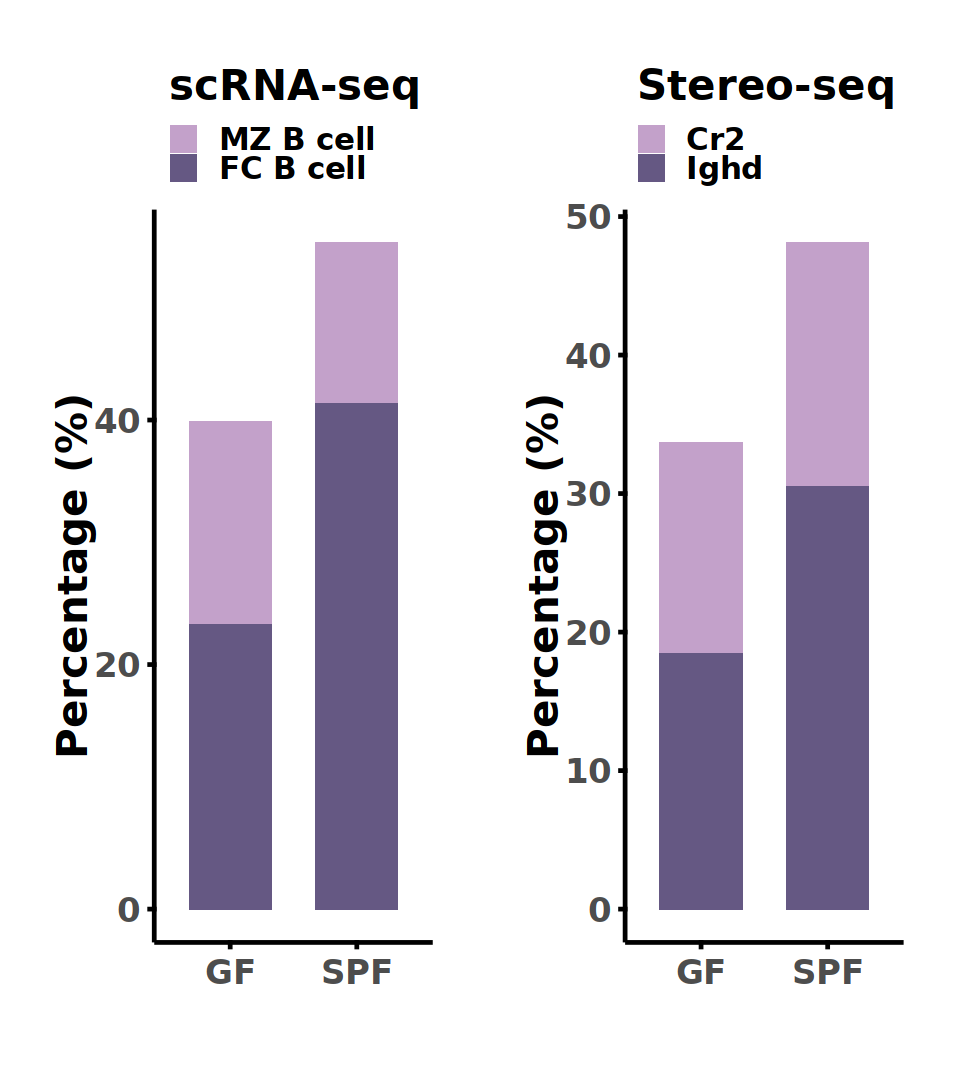

In [78]:
options(repr.plot.width = 8,repr.plot.height= 9)
p <- sc + st 
p

In [79]:
pdf(file = "Figure_2F.pdf",w = 8,h = 8)
print(p)
dev.off()

png 
  2

# Figure 2G 

In [ ]:
# nFetature # 

In [36]:
heatmap_Palette <- colorRampPalette(rev(brewer.pal(11, 'Spectral')))
iPlot <- function(object, features, pt.size = 0.1, cluster_Palette = ColorPalette(50)){
    x_max=max(object@meta.data$x)
    y_min=min(object@meta.data$y)
    plot <- ggplot(object@meta.data, aes_string(x = 'x', y = 'y', color = features)) +
            geom_point_rast(shape = 19, size = pt.size) +
            #geom_point_rast(size=0.1, raster.dpi = getOption("ggrastr.default.dpi", 300))
            theme(axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank(),
                  axis.title = element_blank(), axis.line = element_blank(), legend.position = 'right') +
            coord_fixed()
    
   #if (features %in% c('nCount_Spatial', 'nFeature_Spatial','Plasma1','C11')){
    if (features %in% names(object@meta.data)){
        plot <- plot + scale_color_gradientn(colours = heatmap_Palette(100))+
        annotate("segment", x = x_max-4000, xend = x_max-6000, y = y_min-500, yend =y_min-500,size = 1)+
        annotate("text", x = x_max-2500, y = y_min-500, label = "1000 μm",color="black",size =4 )
    }else if(features %in% c('celltype', 'seurat_clusters')){
        plot <- plot + scale_color_manual(values = cluster_Palette) +
                guides(colour = guide_legend(override.aes = list(size=3), nrow = 4))+
        annotate("segment", x = x_max-4000, xend = x_max-6000, y = y_min-500, yend =y_min-500,size = 1)+
        annotate("text", x = x_max-2500, y = y_min-500, label = "1000 μm",color="black",size =4)
    }
    plot <- plot + theme_void()
    
    return(plot)
}

In [54]:
gf_spleen <- readRDS("GF_spleen.bin50.rds")
spf_spleen <- readRDS("SPF_spleen.bin50.rds")
date()

[1] "Tue Jan 14 23:58:37 2025"

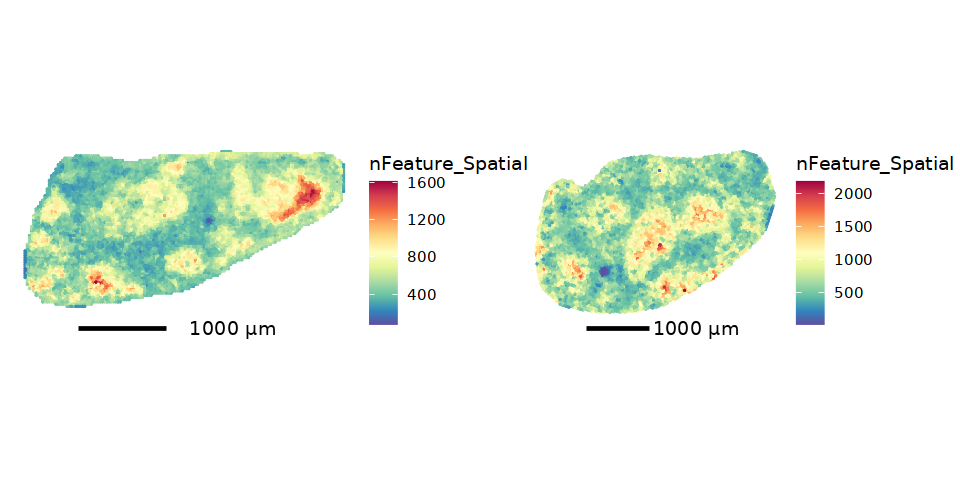

In [55]:
f1=iPlot(gf_spleen, features='nFeature_Spatial', pt.size = 0.1, cluster_Palette = ColorPalette(50))
f2=iPlot(spf_spleen, features='nFeature_Spatial', pt.size = 0.1, cluster_Palette = ColorPalette(50))

options(repr.plot.width = 8,repr.plot.height =4)
p <- f1+f2+plot_layout(ncol = 2)
p

In [56]:
pdf(file = "Figure_2G_spleen_nFeature.pdf",w = 8,h = 4)
print(p)
dev.off()

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '1000 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '1000 μm' in 'mbcsToSbcs': dot substituted for <bc>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '1000 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '1000 μm' in 'mbcsToSbcs': dot substituted for <bc>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '1000 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '1000 μm' in 'mbcsToSbcs': dot substituted for <bc>”
Warning message in grid.Call.graph

png 
  2

In [40]:
gem_2_rds <- function(gem, prefix, binsize){
    #' group counts into bins
    data=fread(file=gem)
    colnames(data)=c("geneID","x","y","MIDCounts")
    data$x <- trunc(data$x / binsize) * binsize
    data$y <- trunc(data$y / binsize) * binsize

    
    if ('MIDCounts' %in% colnames(data)) {

      data <- data[, .(counts=sum(MIDCounts)), by = .(geneID, x, y)]
    } else {
      data <- data[, .(counts=sum(UMICount)), by = .(geneID, x, y)]
    }
    
    #' create sparse matrix from stereo
    data$cell <- paste0(prefix, ':', data$x, '_', data$y)
    data$geneIdx <- match(data$geneID, unique(data$geneID))
    data$cellIdx <- match(data$cell, unique(data$cell))

    
    
    mat <- sparseMatrix(i = data$geneIdx, j = data$cellIdx, x = data$counts, 
                        dimnames = list(unique(data$geneID), unique(data$cell)))

    cell_coords <- unique(data[, c('cell', 'x', 'y')])

    
    rownames(cell_coords) <- cell_coords$cell
    
    
    seurat_spatialObj <- CreateSeuratObject(counts = mat, project = 'Stereo', assay = 'Spatial', 
                                            names.delim = ':', meta.data = cell_coords)
    
    
    #' create pseudo image
    cell_coords$x <- cell_coords$x - min(cell_coords$x) + 1
    cell_coords$y <- cell_coords$y - min(cell_coords$y) + 1
    
    tissue_lowres_image <- matrix(1, max(cell_coords$y), max(cell_coords$x))

    
    tissue_positions_list <- data.frame(row.names = cell_coords$cell,
                                        tissue = 1,
                                        row = cell_coords$y, col = cell_coords$x,
                                        imagerow = cell_coords$y, imagecol = cell_coords$x)
    
    
    scalefactors_json <- toJSON(list(fiducial_diameter_fullres = binsize,
                                     tissue_hires_scalef = 1,
                                     tissue_lowres_scalef = 1))
    
    
    #' function to create image object
    generate_spatialObj <- function(image, scale.factors, tissue.positions, filter.matrix = TRUE){
      if (filter.matrix) {
        tissue.positions <- tissue.positions[which(tissue.positions$tissue == 1), , drop = FALSE]
      }
      
      unnormalized.radius <- scale.factors$fiducial_diameter_fullres * scale.factors$tissue_lowres_scalef
      
      spot.radius <- unnormalized.radius / max(dim(x = image))
      
      return(new(Class = 'VisiumV1', 
                 image = image, 
                 scale.factors = scalefactors(spot = scale.factors$tissue_hires_scalef, 
                                              fiducial = scale.factors$fiducial_diameter_fullres, 
                                              hires = scale.factors$tissue_hires_scalef, 
                                              lowres = scale.factors$tissue_lowres_scalef), 
                 coordinates = tissue.positions, 
                 spot.radius = spot.radius))
    }
    
    spatialObj <- generate_spatialObj(image = tissue_lowres_image, 
                                      scale.factors = fromJSON(scalefactors_json), 
                                      tissue.positions = tissue_positions_list)
    
    #' import image into seurat object
    spatialObj <- spatialObj[Cells(x = seurat_spatialObj)]
    DefaultAssay(spatialObj) <- 'Spatial'
    
    seurat_spatialObj[['slice1']] <- spatialObj
    rm("spatialObj")
    rm("data")
    rm("mat")
    
    return(seurat_spatialObj)
}  
date()

[1] "Tue Jan 14 23:56:05 2025"

In [57]:
gf_gem = "Spleen_GF_local.gem"
spf_gem = "Spleen_SPF_local.gem"

In [58]:
gf_spleen_local = gem_2_rds(gf_gem,prefix="GF", binsize=50)
spf_spleen_local = gem_2_rds(spf_gem,prefix="SPF", binsize=50)
date()

[1] "Tue Jan 14 23:59:40 2025"

In [ ]:
saveRDS(gf_spleen,file = "gf_spleen_local.rds")
saveRDS(spf_spleen,file = "spf_spleen_local.rds")
date()

In [189]:
gf_spleen_local <- readRDS("gf_spleen_local.rds")
spf_spleen_local <- readRDS("spf_spleen_local.rds")

In [190]:
EechPiePlot <- function(obj,marker){ 
    data <- FetchData(obj,vars = marker)
    data <- data.frame(ExpStat = length(data[data[,marker] != 0,]) ,
                       UnExpStat = length(data[data[,marker] == 0,]),
                       gene = marker)
    data <- reshape2::melt(data,id.vars = "gene")
    print(data)
    data$variable <- factor(data$variable,levels = c("UnExpStat","ExpStat"))
    p <- ggplot(data = data, mapping = aes(x = gene, y = value, fill = variable)) + 
    geom_bar(stat = 'identity',  position = 'stack')+ coord_polar(theta = 'y') +
       scale_fill_manual(values=c("#808080","#bd0000")) + 
       labs(x = '', y = '', title = marker) + theme_void() + theme(
       plot.title = element_text(size = 5,face = "bold",hjust = 0.5),
       legend.position = "none",plot.margin = unit(c(0.1,0.1,0.1,0.1),"cm"))
    return(p)
}

In [191]:
Pie1 <- EechPiePlot(obj = gf_spleen_local,marker = "Cr2")
Pie2 <- EechPiePlot(obj = gf_spleen_local,marker = "Ighd")

  gene  variable value
1  Cr2   ExpStat   450
2  Cr2 UnExpStat   890
  gene  variable value
1 Ighd   ExpStat   520
2 Ighd UnExpStat   820


In [192]:
Pie3 <- EechPiePlot(obj = spf_spleen_local,marker = "Cr2")
Pie4 <- EechPiePlot(obj = spf_spleen_local,marker = "Ighd")

  gene  variable value
1  Cr2   ExpStat   457
2  Cr2 UnExpStat  1244
  gene  variable value
1 Ighd   ExpStat   807
2 Ighd UnExpStat   894


In [193]:
gen_exp_filter=function(rds=spf_local_rds,gene=c("Acta2","Myl9")){
    gen=FetchData(rds,vars=gene)
    nam=rownames(gen)
    gen=apply(gen,1,sum)
   
    x=as.numeric(str_split_fixed(nam, "[:_]", 4)[,2]) #SS200000756BR_E3:13750_6550,格式必须一致
    y=as.numeric(str_split_fixed(nam, "[:_]", 4)[,3]) #SS200000756BR_E3:13750_6550,格式必须一致
    new=data.frame(x,y,gen)
    colnames(new)=c("x","y","hotspot")
    pos=which(new$hotspot==0)
    new=new[-pos,]
    pp=which(new$hotspot>1)
    new$hotspot=0
    new[pp,3]=1
    pp=which(new$hotspot==0)
    new=new[-pp,]
    return(new)
}
plot_region <- function(df, df2, symb="Cr2", point_size,values = c("gray10","gray40","gray70","gray90")) {
  x_med = median(df$x)
  ymin = min(df$y)
  x1 = x_med - 500      # bin50 25um, 200/50 表示4个spot, 4*25=100um,  1000/50 * 25 = 500um
  x2 = x_med + 500
  y1 = ymin - 200
  theme_self <- theme(axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank(),                                                                                                                                     
          axis.title = element_blank(), axis.line = element_blank(), legend.position = 'right',
          plot.title = element_text(hjust = 0.5,vjust = 0.5,size = 15,face = "bold"))
  R<-ggplot() +  
    geom_contour_filled(df,mapping=aes(x=x, y=y, z=as.numeric(Cell)),breaks=0:5) + theme_void() +                                                                                                                                      
    coord_fixed()  + 
    scale_fill_manual(labels = c("1","2","3","4"), values = values) +
    guides(fill=guide_legend(override.aes = list(size=5), nrow = 4, title = 'Layers'))  + 
    geom_point(df2, mapping=aes(x = x, y = y, color="hotsopt"), shape = 19,
               size = point_size,stroke=NA,col='red') +
    ggtitle(symb)+ 
    guides(colour = guide_legend(override.aes = list(size=3), nrow = 5, title = ''))  + 
    annotate("segment", x = x1, xend = x2, y = y1, yend =y1,size = 1) +
    annotate("text", x = x2 + 500, y = y1, label = "500 μm",color="black",size = 5, fontface="bold" ) + 
    theme_self 
     
  R
}

In [194]:
SPF_layer=read.table("SPF.bayescluster.cluster_infor.xls",header=T)
GF_layer=read.table("GF.bayescluster.cluster_infor.xls",header=T)

In [195]:
df=GF_layer[,c(2,3,6)]
names(df)=c("x","y","Cell")

df_Cr2_fil=gen_exp_filter(gf_spleen_local,gene="Cr2")
df_Ighd_fil=gen_exp_filter(gf_spleen_local,gene="Ighd")

f1=plot_region(df, df_Cr2_fil, symb="MZ cell(Cr2)", point_size=1.8,
              values = c("gray90","gray70","gray40","gray10")) 
f2=plot_region(df, df_Ighd_fil, symb="FC cell(Ighd)", point_size=1.8,
              values = c("gray90","gray70","gray40","gray10"))

In [196]:
df=SPF_layer[,c(2,3,6)]
names(df)=c("x","y","Cell")
rownames(df)=paste("SPF:",df[,1],"_",df[,2],sep="")
 
df_Cr2_fil=gen_exp_filter(spf_spleen_local,gene="Cr2")
df_Ighd_fil=gen_exp_filter(spf_spleen_local,gene="Ighd")

f3=plot_region(df, df_Cr2_fil, symb="MZ cell(Cr2)", point_size=1.8,
              values = c("gray10","gray40","gray90","gray70")) 
f4=plot_region(df, df_Ighd_fil, symb="FC cell(Ighd)", point_size=1.8,
              values = c("gray10","gray40","gray90","gray70")) 


In [197]:
layout <- c(area(1,1,3,3),
           area(2,4,2),
           area(1,5,3,7),
           area(2,8,2),
           area(4,1,6,3),
           area(5,4,5), 
           area(4,5,6,7),
           area(5,8,5))

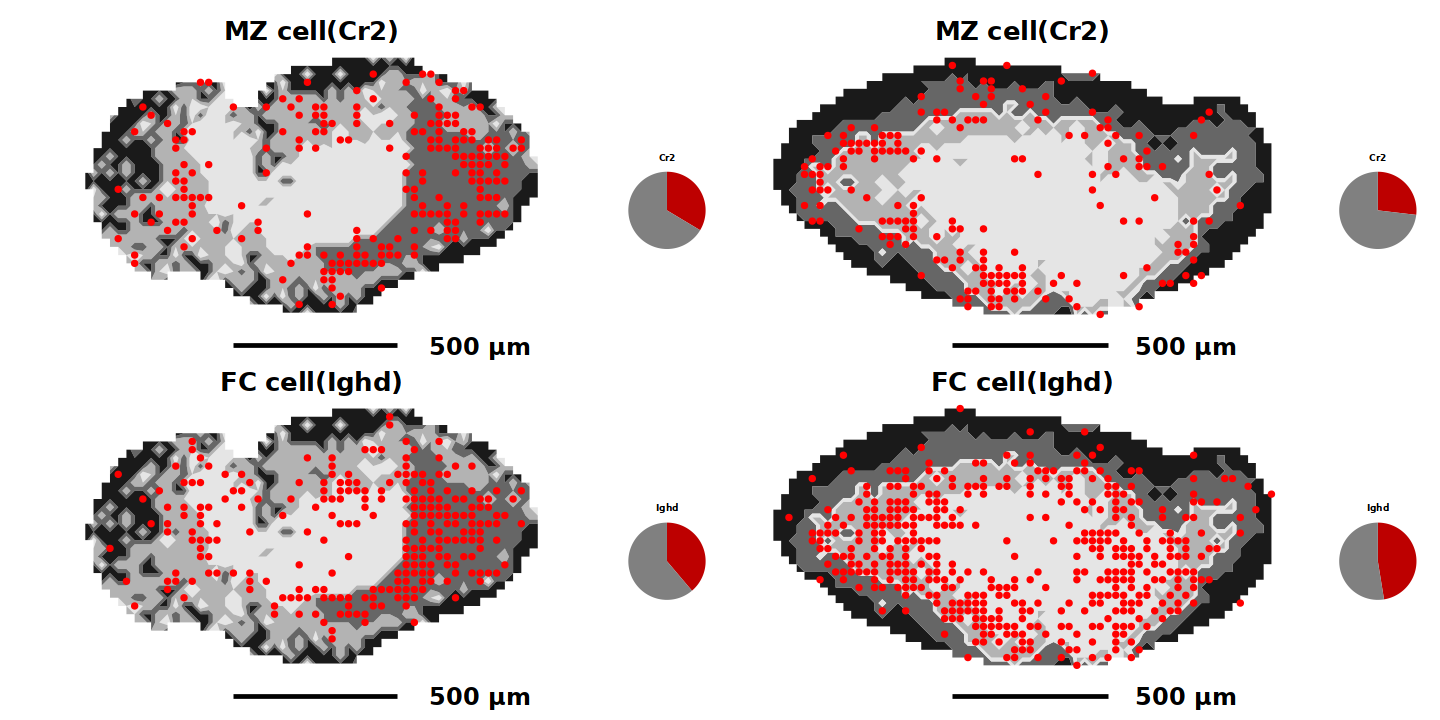

In [199]:
options(repr.plot.width = 12,repr.plot.height = 6)
p <- f1 + Pie1 + f3 + Pie3 + f2 + Pie2 + f4 + Pie4 + 
    plot_layout(design = layout,guides='collect') & NoLegend()
p

In [200]:
pdf(file = "Figure_2G.pdf",w = 12,h = 6)
print(p)
dev.off()

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <bc>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <bc>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <bc>”
Warning message in grid.Call.graphics(C_

png 
  2

# Figure 2H

In [80]:
TidyData <- function(obj,idx,idents=NULL){
  if(!is.null(idents)){
    pritn("Idents is not NULL!")
    Idents(obj) <- idents  
  }
  sub <- subset(obj,idents = idx)
  sub@meta.data$celltypes <- as.vector(sub@meta.data$celltypes )
  stat <- table(sub@meta.data$tissue,sub@meta.data$celltypes)
  data <- as.data.frame(proportions(as.matrix(stat),margin = 1) * 100)
  colnames(data) <- c("tissue","celltypes","percentage")
  return(data)
}
CellRadioBarplot <- function(data,mycolor,title = NULL){ 
  theme_self <- theme(
    axis.text.y = element_text(size = 20,face = "bold",margin  = margin(0,5,0,0)),
    axis.text.x = element_text(size = 20,face = "bold",margin  = margin(0,0,0,0),angle = 45,hjust = 1,vjust =0.9),
    axis.title.x= element_text(size = 25,face = "bold",margin  = margin(0,0,0,0)),
    axis.title.y= element_text(size = 25,face = "bold",margin  = margin(0,0,0,0)),
    axis.line = element_line(linetype = 1,color= "black",size = 1),
    legend.text = element_text(size = 18,face = "bold"),
    legend.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin =  unit(c(1,1,1,1),"cm"), 
    axis.ticks  = element_line(color = "black",size = 1,lineend = 2),
    plot.title = element_text(hjust = 0.5,size = 30,face = "bold"))
  p <- ggplot(data,aes(x = tissue,y = percentage,fill = celltypes)) + 
    geom_bar(stat="identity",width = 0.7) + theme_classic()+ labs(x = " " , y = "Percentage (%)") +  
    scale_fill_manual(values=mycolor) + theme_self + 
    guides(fill=guide_legend(position = "top",nrow = 1)) + ggtitle(title) + 
    theme(legend.position = "top")
  return(p)
}
TidyMiceData <- function(obj,idx = c("IgA plasma","IgG plasma","Plasma cycling","IgM plasma")){
  obj@meta.data$celltypes <- as.vector(obj@meta.data$celltypes)
  stat <- as.data.frame.array(table(obj@meta.data$celltypes,obj@meta.data$mice))
  stat <- as.data.frame(proportions(as.matrix(stat),margin = 2) * 100)
  stat$celltypes <- rownames(stat)
  stat <- stat[stat$celltypes %in% idx,]
  stat <- reshape2::melt(stat,id.vars = "celltypes")
  colnames(stat) <- c("celltypes","mice","percentage")
  return(stat)
}

In [75]:
bcells <- readRDS("immune_bcells_final_annotation.rds")

In [76]:
level <- c("IgA plasma","IgG plasma","Plasma cycling","IgM plasma")

# GF # 
GF <- subset(bcells,subset = mice == "GF")
gf_bcell <- TidyData(obj = GF,idx = c(14,15,16,17))
mycolor = c("#655883","#C3A1CA","#DEBE98","#B0B1B2")
names(mycolor) <- level
gf_bcell$celltypes <- factor(gf_bcell$celltypes,levels = level)
gf_Ig <- CellRadioBarplot(data = gf_bcell,mycolor = mycolor,title = "GF")

In [77]:
# SPF # 
SPF <- subset(bcells,subset = mice == "SPF")
spf_bcell <- TidyData(obj = SPF,idx = c(14,15,16,17))
spf_bcell$celltypes <- factor(spf_bcell$celltypes,levels = level)
spf_Ig <- CellRadioBarplot(data = spf_bcell,mycolor = mycolor,title = "SPF")

In [81]:
# whole # 
whole <- TidyMiceData(obj = bcells)
whole$mice <- factor(whole$mice,levels = c("SPF","GF"))
whole$celltypes <- factor(whole$celltypes,levels = level)
whole_Ig <- CellMiceRadioBarplot(data = whole,mycolor = mycolor,x = "mice",y = "percentage",
                                 fill = "celltypes",title = "",legend = "horizontal",nrow = 1)

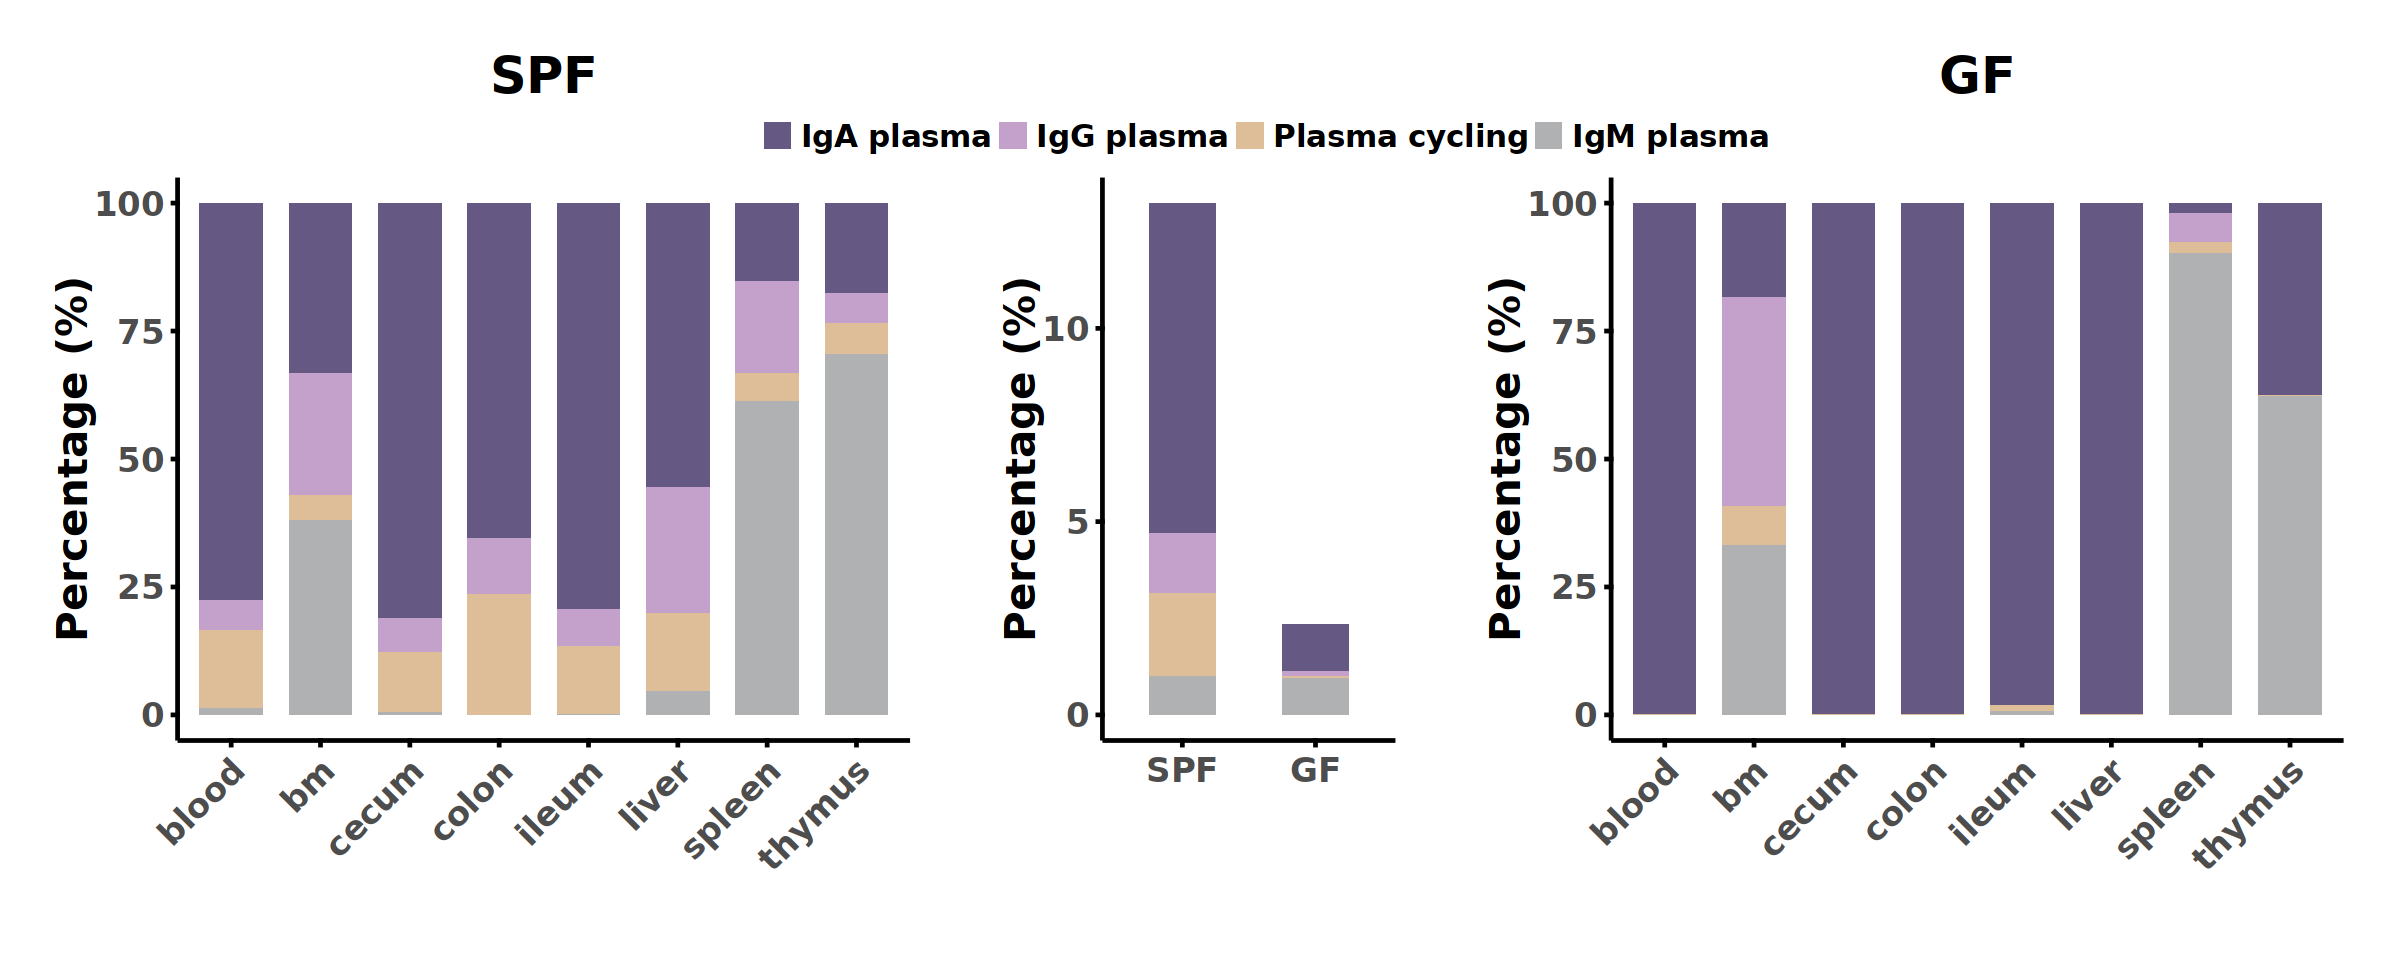

In [82]:
options(repr.plot.width = 20,repr.plot.height= 8)
p <- spf_Ig + whole_Ig + gf_Ig + plot_layout(widths = c(2,0.8,2),guides = 'collect') & theme(legend.position='top')
p

In [83]:
pdf(file = "Figure_2H.pdf",w = 20,h = 8)
print(p)
dev.off()

png 
  2